# Generative Spaces (ABM)

In this workshop we will learn how to construct a ABM (Agent Based Model) with spatial behaviours, that is capable of configuring the space. This file is a simplified version of Generative Spatial Agent Based Models. For further information, you can find more advanced versions here:

* [Object Oriented version](https://github.com/shervinazadi/spatial_computing_workshops/blob/master/notebooks/w3_generative_spaces.ipynb)
* [Vectorized version](https://topogenesis.readthedocs.io/notebooks/random_walker)

## 0. Initialization

### 0.1. Load required libraries

In [1]:
# !pip install pyvista==0.28.1 ipyvtklink

In [2]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
import scipy as sp
import pickle
import matplotlib.pyplot as plt
np.random.seed(0)

## Parameter settings

In [3]:
# The number of frames of the growth model
n_frames = 500

### 0.2. Define the Neighborhood (Stencil)

In [4]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)

In [5]:
# creating neighborhood definition
stencil_sq = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
# stencil_sq.set_index([0,0,0], 0)
stencil_sq.set_index([0,0,1], 0)
stencil_sq.set_index([0,0,-1], 0)

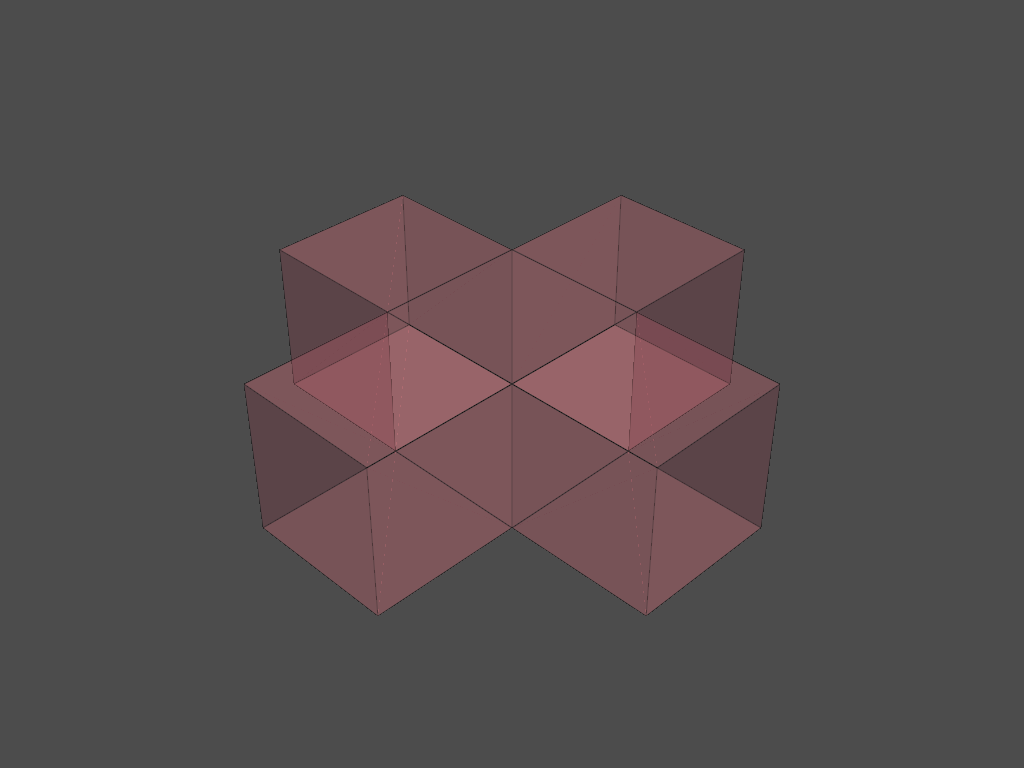

[(6.361720043489708, 6.361720043489708, 6.361720043489708),
 (1.5, 1.5, 1.5),
 (0.0, 0.0, 1.0)]

In [6]:
p = pv.Plotter(notebook=True)
grid = pv.UniformGrid()

grid.dimensions = np.array(stencil_sq.shape) + 1
grid.origin = [0,0,0]
grid.spacing = [1,1,1]

grid.cell_arrays["values"] = stencil_sq.flatten(order="F")
threshed = grid.threshold([0.9, 1.1])

p.add_mesh(threshed, show_edges=True, color="#ff8fa3", opacity=0.3)
p.show()

## 1. Setup the Environment

### 1.1. Load the envelope lattice as the avialbility lattice

In [7]:
# loading the lattice from csv
lattice_path = os.path.relpath('../Data/dynamic output/voxelized_envelope_cut.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)

### 1.2 Load Program

In [8]:
# Load agent sizes
sizes_complete = pd.read_csv("../Data/raw data/Agent_sizes.csv")
Area = sizes_complete['Area']
sizes_complete = sizes_complete.sort_values(by = 'Area', ascending=0)
display(sizes_complete)

,Agent,Agent_id,Area
6,Vegetation,6,10000
3,Starter housing (100 units),3,9000
1,Student housing (4 persons),1,4800
4,Parking spaces (minimal of 0.5 per apartement),4,4000
9,Co-working space,9,3000
0,Student housing (1 person),0,2400
7,Workshops,7,2000
10,Start-up offices,10,2000
2,Assisted living (30 units),2,1800
17,Restaurant,17,1000


In [9]:
# Calculating agent sizes in voxels
agent_areas = []
for i, row in sizes_complete.iterrows():
    part = row['Area']
    agent_areas.append(part)

In [10]:
# Load preference
square_weight = 100

program_complete = pd.read_csv("../Data/raw data/Programme_pref.csv")
program_complete = program_complete.drop(["sunlight"], 1)
program_complete['noise_field'] *= -1
program_complete['dist_entrance'] *= -0.3
program_complete['dist_fac'] *= -0.1

program_complete['Area'] = Area
program_complete = program_complete.sort_values(by='Area',ascending=0)
program_complete = program_complete.drop(['Area'],1)

program_complete

,space_name,space_id,noise_field,dist_entrance,dist_fac,skyview
6,Vegetation/park,6,-0.5,-0.105,-0.053,0.0
3,Starter Housing,3,-0.6,-0.180,-0.093,0.6
1,Student Housing 4 p,1,-0.4,-0.165,-0.087,0.6
4,Underground Parking4,0,-0.8,-0.021,-0.020,0.0
9,Co-working Space,9,-0.5,-0.180,-0.067,0.4
0,Student Housing 1 p,0,-0.4,-0.165,-0.087,0.6
7,Workshops,7,-0.3,-0.195,-0.070,0.4
10,Start-up Offices,10,-0.2,-0.180,-0.060,0.6
2,Assisted Living,2,-0.8,-0.120,-0.093,0.8
17,Restaurant,17,-0.6,-0.180,-0.060,0.7


In [11]:
# Simplify it
program_prefs = program_complete.drop(["space_name","space_id"], 1)

### 1.2 Load the value fields

In [12]:
# loading the lattice from csv
fields = {}
for f in program_prefs.columns:
    lattice_path = os.path.relpath('../Data/dynamic output/' + f + '.csv') # should care naming of csv
    fields[f] = tg.lattice_from_csv(lattice_path)

### 1.3. Initialize the Agents

In [13]:
# initialize the occupation lattice
occ_lattice = avail_lattice * 0 - 1 # -1 means no agent is using it

agn_num = len(program_complete) 

# Calculate best starting point
# The order to calculate is based on their sizes
agn_locs = []
for a_id, a_prefs in program_complete.iterrows():
    avail_index = np.array(np.where(avail_lattice)).T
    a_eval = np.ones(len(avail_index))
    for f in program_prefs.columns:
        vals = fields[f][avail_index[:,0], avail_index[:,1], avail_index[:,2]]
        # raise the the raw value to the power of preference weight of the agent
        a_weighted_vals = vals ** a_prefs[f]
        # multiply them to the previous weighted values
        a_eval *= a_weighted_vals
    for i in range(len(a_eval)):
        if a_eval[i] == np.inf:
            a_eval[i] = -1
    selected_int = np.argmax(a_eval)
    agn_locs.append([avail_index[selected_int]])
    avail_lattice[tuple(avail_index[selected_int])] = 0
    occ_lattice[tuple(avail_index[selected_int])] = a_id

divide by zero encountered in power


### 1.4. Visualize the environment

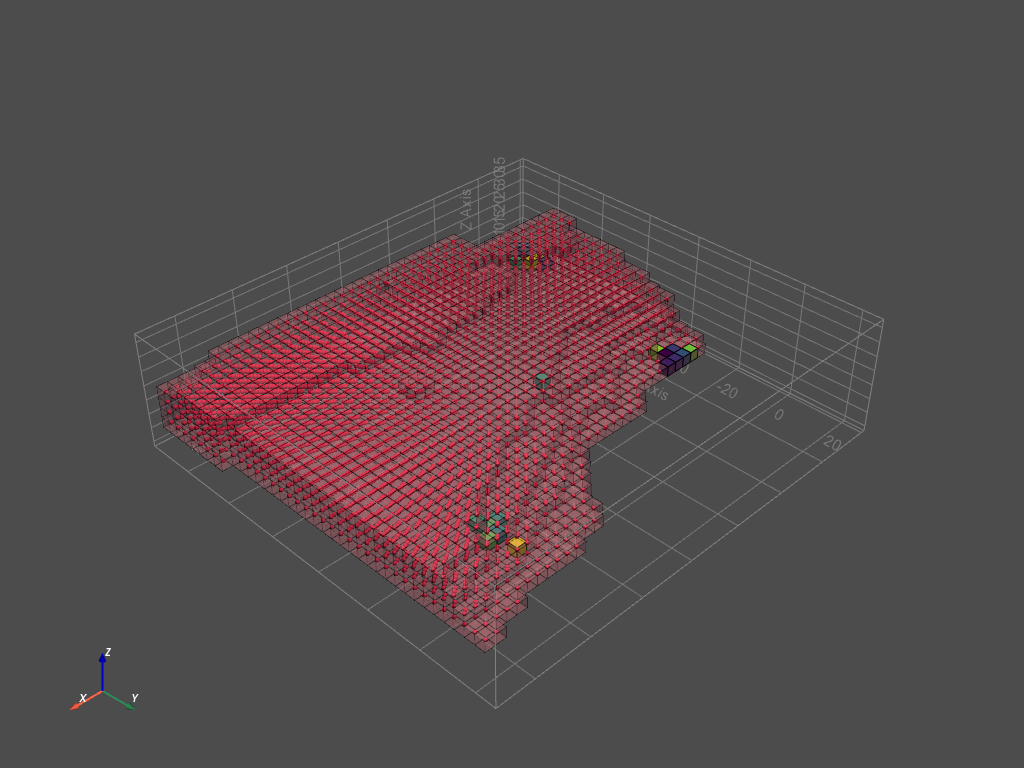

[(275.910778145043, 194.91077814504303, 257.91077778741516),
 (36.0, -45.0, 17.99999964237213),
 (0.0, 0.0, 1.0)]

In [14]:
p = pv.Plotter(notebook=True)

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(occ_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = occ_lattice.minbound - occ_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = occ_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#777777")
# making space list with index for the sargs
#space_list = program_prefs.get('Agent')
# formatting for the sarg annotation
#space_list = space_list.to_dict()

#sargs = dict(
 #   shadow = True,
  #  n_labels = 0,
   # italic = False,
    #fmt=" %.0f",
    #font_family="arial",
    #height = 0.6,
    #vertical = True,
    #position_x = 1.05,
    #position_y = 1)
    
# Add the data values to the cell data
grid.cell_arrays["Agents"] = occ_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([-0.1, agn_num - 0.9])
# adding the voxels
p.add_mesh(threshed, show_edges=True, opacity=1.0, show_scalar_bar=False)

# adding the availability lattice
init_avail_lattice.fast_vis(p)

p.show()

### Cluster existing voxels

In [15]:
# extract the address of all occupied voxels
occ_ind = np.array(np.where(occ_lattice > -1)).T

# construct kmeans model and fit it to find the clustering
kmeans_model = KMeans(n_clusters=4, random_state=0).fit(occ_ind)

### Make vertical shafts

In [16]:
# extract cluster centers
cluster_centers = np.round(kmeans_model.cluster_centers_).astype(np.int8)
# init shaft lattice
shft_lattice = occ_lattice * 0
# set the shafts
for cl_cen in cluster_centers:
    shft_lattice[cl_cen[0],cl_cen[1],:] = 1

### Visualize

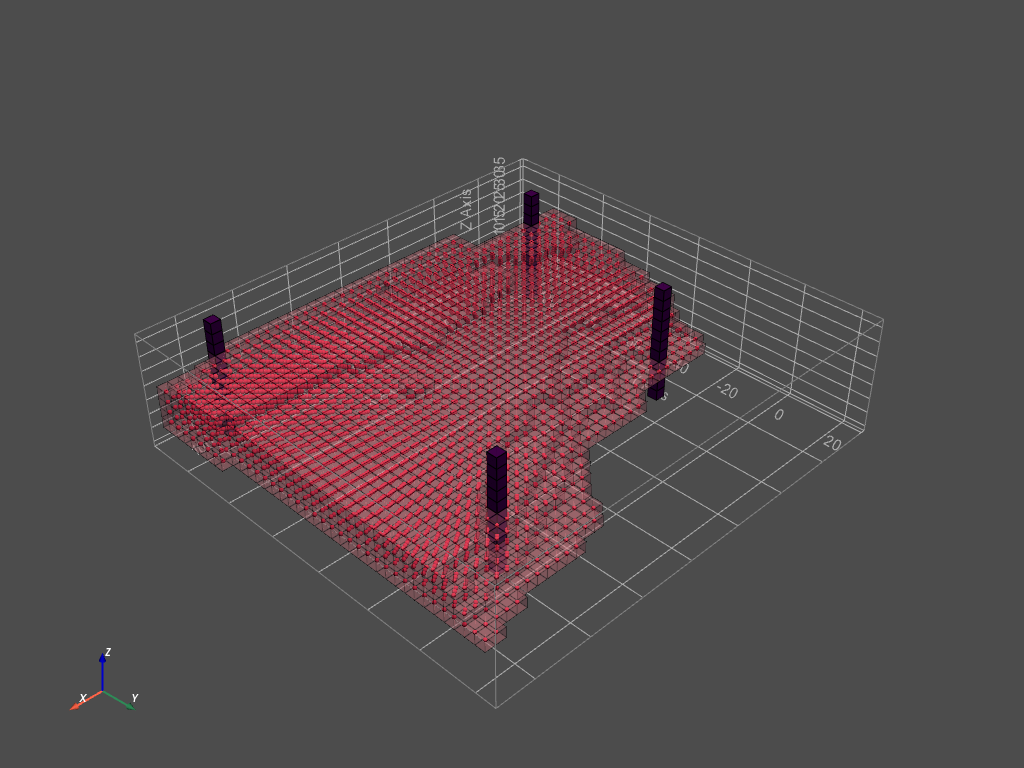

[(275.910778145043, 194.91077814504303, 257.91077778741516),
 (36.0, -45.0, 17.99999964237213),
 (0.0, 0.0, 1.0)]

In [17]:
p = pv.Plotter(notebook=True)

base_lattice = shft_lattice

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")


# Add the data values to the cell data
grid.cell_arrays["Agents"] = base_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([0.9, 1.1])
# adding the voxels
p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)


# p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic", pointa=(0.1, 0.1), pointb=(0.9, 0.1))
p.show()

## Create horizontal corridors

### Extract the connectivity graph from the lattice based on the horizontal stencil

In [18]:
# find the number of all voxels
vox_count = avail_lattice.size 

# initialize the adjacency matrix
adj_mtrx = np.zeros((vox_count,vox_count))

# Finding the index of the available voxels in avail_lattice
avail_index = np.array(np.where(avail_lattice == 1)).T

# fill the adjacency matrix using the list of all neighbours
for vox_loc in avail_index:
    # find the 1D id
    vox_id = np.ravel_multi_index(vox_loc, avail_lattice.shape)
    # retrieve the list of neighbours of the voxel based on the stencil
    vox_neighs = avail_lattice.find_neighbours_masked(stencil, loc = vox_loc)
    # iterating over the neighbours
    for neigh in vox_neighs:
        # setting the entry to one
        adj_mtrx[vox_id, neigh] = 1.0

# construct the graph 
g = nx.from_numpy_array(adj_mtrx)


In [19]:
adj_mtrx[100].sum()

0.0

### Find the shortest path and construct the corridor

In [20]:
# initialize corridor lattice
cor_lattice = shft_lattice * 0
cor_flat = cor_lattice.flatten()
# for each voxel that needs to have access to shafts
for a_vox in occ_ind:
    
    # slice the corridor lattice horizontally
    cor_floor = shft_lattice[:,:,a_vox[2]]
    # find the vertical shaft voxel indices
    shaft_vox_inds = np.array(np.where(cor_floor > 0)).T
    paths = []
    path_lens = []
    for shft_ind in shaft_vox_inds:
        # construct the destination address
        dst_vox = np.array([shft_ind[0],shft_ind[1],a_vox[2]])
        # construct 1-dimensional indices
        src_ind = np.ravel_multi_index(a_vox, shft_lattice.shape)
        dst_ind = np.ravel_multi_index(dst_vox, shft_lattice.shape)
        # find the shortest path
        path = nx.algorithms.shortest_paths.astar.astar_path(g, src_ind, dst_ind)
        paths.append(path)
        path_lens.append(len(path))
    
    # find the shortest path
    shortest_path = paths[np.array(path_lens).argmin()]

    # set the shortest path occupied in the 
    cor_flat[shortest_path] = 1

# reshape the flat lattice
cor_lattice = cor_flat.reshape(cor_lattice.shape)

NetworkXNoPath: Node 3789 not reachable from 2260

### Visualize the accessability lattice

In [ ]:
p = pv.Plotter(notebook=True)

base_lattice = shft_lattice + cor_lattice

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")


# Add the data values to the cell data
grid.cell_arrays["Agents"] = base_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([0.9, 2.1])
# adding the voxels
p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)


# p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic", pointa=(0.1, 0.1), pointb=(0.9, 0.1))
p.show()

## 2. ABM Simulation (Agent Based Space Occupation)

### 2.1. Running the simulation

In [21]:
program_test = pd.read_csv("../Data/raw data/adjacency_matrix.csv")
program_test = program_test.drop(["Unnamed: 0"], 1)
program_test

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.1,0.0,0.0,0.0,0.6,0.1,0.0,0.0,0.0,...,0.0,0.0,0.3,0.2,0.0,0.0,0.0,0.9,0.9,0.1
1,0.1,1.0,0.0,0.0,0.0,0.6,0.0,0.0,0.1,0.0,...,0.2,0.8,0.2,0.0,0.3,0.2,0.0,0.8,0.0,0.6
2,0.0,0.0,1.0,0.4,0.2,0.0,0.1,0.2,0.0,0.0,...,0.0,0.0,0.1,0.1,0.1,0.2,0.6,0.3,0.1,0.0
3,0.0,0.0,0.4,1.0,0.9,0.0,1.0,0.0,0.1,0.8,...,0.2,0.6,0.2,0.2,0.0,0.2,0.3,0.9,0.6,0.0
4,0.0,0.0,0.2,0.9,1.0,0.0,0.0,0.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.9,0.2,0.0
5,0.6,0.6,0.0,0.0,0.0,1.0,0.2,0.0,0.0,0.0,...,0.1,0.2,0.1,0.0,0.0,0.2,0.0,0.2,0.0,0.0
6,0.1,0.0,0.1,1.0,0.0,0.2,1.0,0.1,0.0,0.0,...,0.1,0.2,0.0,0.1,0.1,0.1,0.5,0.0,0.0,0.4
7,0.0,0.0,0.2,0.0,0.0,0.0,0.1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.1,0.0,0.1,0.4,0.0,0.0,0.0,1.0,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.8


In [ ]:
# # Calculate distance
# lattice_cens = init_avail_lattice.centroids_threshold(-1)
# def distance(a_id,fns):
#     fns_cens = []
#     for fn in fns:
#         fns_cens.append(lattice_cens[np.ravel_multi_index(fn,avail_lattice.shape)])
    
#     dist_m = []
#     for voxel_cen in fns_cens:
#         dist_v = []
#         for agent_location in agn_locs[a_id]:
#             diff = voxel_cen - agent_location
#             diff_p2 = diff**2
#             diff_p2s = diff_p2.sum()
#             dist = diff_p2s**0.5
#             dist_v.append(dist)
#         dist_m.append(dist_v)
#     dist_m = np.array(dist_m)
#     min_dist = dist_m.min(axis=1)
#     return(min_dist)
    

In [22]:
# Calculate distance
# This is a stupid but doable estimate for faster calculation
lattice_cens = init_avail_lattice.centroids_threshold(-1)
def distance(a_id,fns):
    fns_cens = []
    for fn in fns:
        fns_cens.append(lattice_cens[np.ravel_multi_index(fn,avail_lattice.shape)])
    
    dist_m = []
    for voxel_cen in fns_cens:
        diff = voxel_cen - np.average(agn_locs[a_id],axis=0)
        diff_p2 = diff**2
        diff_p2s = diff_p2.sum()
        dist = diff_p2s**0.5
        dist_m.append(dist)
    dist_m = np.array(dist_m)
    return(dist_m)

In [23]:
# make a deep copy of occupation lattice
cur_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
# initialzing the list of frames
frames = [cur_occ_lattice]

# setting the time variable to 0
t = 0

# main feedback loop of the simulation (for each time step ...)
while t<n_frames: # For every time
    # for each agent ...
    for a_id, a_prefs in program_complete.iterrows():
        # retrieve the list of the locations of the current agent
        a_locs = agn_locs[a_id]
        # initialize the list of free neighbours
        free_neighs = []
        free_neighs_sq = []
        # for each location of the agent
        for loc in a_locs:
            # retrieve the list of neighbours of the agent based on the stencil
            neighs = avail_lattice.find_neighbours_masked(stencil, loc = loc)
            neighs_sq = avail_lattice.find_neighbours_masked(stencil_sq, loc = loc)
            # for each neighbour ... 
            for n in neighs:
                # compute 3D index of neighbour
                neigh_3d_id = np.unravel_index(n, avail_lattice.shape) # for checking availability
                # if the neighbour is available... 
                if avail_lattice[neigh_3d_id]: # True -> Free
                    # add the neighbour to the list of free neighbours
                    free_neighs.append(neigh_3d_id) # Do not care about counting for the second time.
            for n in neighs_sq:
                neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
                if avail_lattice[neigh_3d_id]:
                    free_neighs_sq.append(neigh_3d_id)
        # check if found any free neighbour
        if len(free_neighs)>0:
            # convert free neighbours to a numpy array
            fns = np.array(free_neighs)

            # find the value of neighbours
            # init the agent value array
            a_eval = np.ones(len(fns)) # First set all values to 1
            # This is the part to make amandment on choosing which block
            # for each field...
            for f in program_prefs.columns: # f represents names
                # find the raw value of free neighbours...
                vals = fields[f][fns[:,0], fns[:,1], fns[:,2]] # vals should be an array of length of fns
                # raise the the raw value to the power of preference weight of the agent
                a_weighted_vals = vals ** a_prefs[f]
                # multiply them to the previous weighted values
                a_eval *= a_weighted_vals
            
            # now this part add the desirable space vicinity into the account
            for s in program_test.columns:
                s = int(s)
                vals = distance(s,fns)
                a_weighted_vals = vals ** program_test[str(a_id)][s]
                a_eval *= a_weighted_vals

            # This is the part that takes square shape of room into the account
            free_neighs_count = []
            # count can find how many times a location appears
            for free_neigh in free_neighs:
                free_neighs_count.append(free_neighs_sq.count(free_neigh))
            # If a location is pointed for several times, it refers to more squared shape
            a_weighted_square = np.array(free_neighs_count) ** square_weight
            a_eval *= a_weighted_square

            # Here, when it reaches the maximum space needed, start to evaluate inner voxels
            current_length = np.copy(len(a_locs))
            # This part means nothing, just for prevention of bugs
            i_eval = np.zeros(current_length)
            # max_space can be modified, or iterable (max_space[a_id])
            max_space_raw = agent_areas[a_id] / (avail_lattice.unit[0] * avail_lattice.unit[1])
            max_space = np.rint(max_space_raw)
            #max_space = 20
            # If the space occupied by this agent reaches designated
            if current_length >= max_space:
                i_eval = np.ones(current_length)
                # The following parts do exactly the same calculations
                # Calculating fields
                for f in program_prefs.columns:
                    vals = fields[f][np.array(a_locs)[:,0], np.array(a_locs)[:,1], np.array(a_locs)[:,2]]
                    a_weighted_vals = vals ** a_prefs[f]
                    i_eval *= a_weighted_vals

                # Calculating closeness
                for s in program_test.columns:
                    s = int(s)
                    vals = distance(s,np.array(a_locs))
                    a_weighted_vals = vals ** program_test[str(a_id)][s]
                    i_eval *= a_weighted_vals
                
                # Calculating squareness is bit different but the idea is same.
                i_neighs_count = np.zeros(current_length)
                for id,loc in enumerate(a_locs):
                    # Find neighbors of each point in location
                    neighs = init_avail_lattice.find_neighbours_masked(stencil_sq, loc = loc)
                    for n in neighs:
                        # Use occ_lattice == a_id to check if the neighborhoods of that point are the same agent.
                        neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
                        i_neighs_count[id] += (occ_lattice==a_id)[neigh_3d_id]
                i_weighted_square = np.array(i_neighs_count) ** square_weight
                i_eval *= i_weighted_square

            # select the inner with lowest evaluation
            selected_int_inner = np.argmin(i_eval)
            # select the neighbour with highest evaluation
            selected_int = np.argmax(a_eval)

            # If the agent reaches the required space, and the new free neighbour is better
            # Then we have to remove the old voxel
            if (current_length >= max_space) and i_eval[selected_int_inner] < a_eval[selected_int]:
                selected_inner_3d_id = tuple(a_locs[selected_int_inner])
                selected_inner_loc = a_locs[selected_int_inner]
                agn_locs[a_id].pop(selected_int_inner)
                avail_lattice[selected_inner_3d_id] = 1
                occ_lattice[selected_inner_3d_id] = -1

            # If the agent does not reach the required space, or we already removed old voxel
            # Then we need to add new voxel
            if (not current_length >= max_space) or (current_length >= max_space and i_eval[selected_int_inner] < a_eval[selected_int]):
                # find 3D integer index of selected neighbour
                selected_neigh_3d_id = free_neighs[selected_int]
                # find the location of the newly selected neighbour
                selected_neigh_loc = np.array(selected_neigh_3d_id).flatten()
                # add the newly selected neighbour location to agent locations
                agn_locs[a_id].append(selected_neigh_loc)
                # set the newly selected neighbour as UNavailable (0) in the availability lattice
                avail_lattice[selected_neigh_3d_id] = 0
                # set the newly selected neighbour as OCCUPIED by current agent 
                # (-1 means not-occupied so a_id)
                occ_lattice[selected_neigh_3d_id] = a_id
            
            # If the agent reaches the required space and the old voxels are better, we do nothing

    # constructing the new lattice
    new_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
    # adding the new lattice to the list of frames
    frames.append(new_occ_lattice) # For drawing graphes
    # adding one to the time counter
    print(t, end=" ")
    t += 1

divide by zero encountered in power
invalid value encountered in multiply


0 1 2 3 4 5 6 7 8 9 10 11 12 13 

divide by zero encountered in power


14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 28

### 2.2. Visualizing the simulation

In [ ]:
p = pv.Plotter(notebook=True)

base_lattice = frames[0]

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

def create_mesh(value):
    f = int(value)
    lattice = frames[f]

    # Add the data values to the cell data
    grid.cell_arrays["Agents"] = lattice.flatten(order="F").astype(int)  # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([-0.1, agn_num - 0.9])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)
    return

p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic")
p.show(use_ipyvtk=True)

### 2.3. Saving lattice frames in CSV

In [24]:
for i, lattice in enumerate(frames):
    csv_path = os.path.relpath('../Data/dynamic output/abm_animation/abm_f_'+ f'{i:03}' + '.csv')
    lattice.to_csv(csv_path)

### Credits

In [ ]:
__author__ = "Shervin Azadi "
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Agent Based Models for Generative Spaces"